In [1]:
!pip install numpy pandas matplotlib seaborn pymc3

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [15, 5]

## Nacteni dat

In [3]:
df = pd.read_excel('./211026_DEMO.xlsx')
df

,ID survey,Wintered,Lost total,Group
0,20190005,16,6,OA trickling
1,20190006,31,4,OA trickling
2,20190007,55,23,OA trickling
3,20190010,7,0,OA trickling
4,20190013,90,1,OA trickling
...,...,...,...,...
10351,20211766,7,1,Drone brood removal
10352,20211771,5,1,Drone brood removal
10353,20211772,50,5,Drone brood removal
10354,20211774,6,0,Drone brood removal


In [4]:
df['Relative loss'] = df['Lost total'] / df['Wintered']
df['Group'] = df['Group'].astype('category')

In [5]:
df['Group'].unique()

['OA trickling', 'FA short', 'Hyperthermia', 'Drone brood removal']
Categories (4, object): ['Drone brood removal', 'FA short', 'Hyperthermia', 'OA trickling']

In [6]:
code_to_group = dict(enumerate(df['Group'].cat.categories))
code_to_group

{0: 'Drone brood removal', 1: 'FA short', 2: 'Hyperthermia', 3: 'OA trickling'}

In [7]:
assert not (df['Lost total'] > df['Wintered']).any()
# df[df['Lost total'] > df['Wintered']]

# df[df['Wintered'] < 0]
# df[df['Relative loss'] < 0]

## Vizualizace
Nejrozumnejsi je divat se na "stripplot" nize. Ostatni vizualizace jsou velmi zavadejici. Boxplot je uple k nicemu.
Rozumny je mozna jeste histplot (odkomentuj nize) – je ale treba davat pozor na interpretaci osy X.

<AxesSubplot:xlabel='Group', ylabel='Relative loss'>

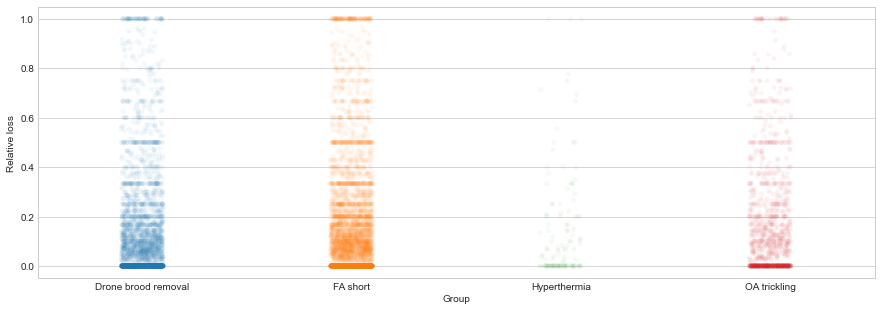

In [8]:
sns.stripplot(data=df, x='Group', y='Relative loss', alpha=0.05)

In [9]:
# Boxplot je uplne na houby.
# sns.boxplot(data=df, x='Group', y='Relative loss')

In [10]:
# sns.histplot(data=df, x='Relative loss', hue='Group', multiple='dodge', bins=10, common_norm=False, stat='density')

## Model
Nasledujici model si lze predstavit jako hod ohlou minci. Kazda skupina dostane ohlou minci – hod minci urcuje, zda vcelstvo pres zimu uhyne. Nasim ukolem je zjistit, jak moc je mince ohnuta. Tedy, jaka je pravdepodobnost, ze vcelstvo uhyne.

Vystupem je distribuce pravdepodobnosti uhynu vcelstva. Pro kazdou skupinu zvlast. Distribuce se nachazi mezi 0 a 1 (jedna se o pravdepodonost). Cim je vetsi, tim vetsi je sance uhynu vcelstva.

Tento pristup se diva na kazde vcelstvo zvlast, neresi efekt vcelare.

Jedna se o velmi jednoduchy model, typicky prezentovany pri uvodu do Bayesovskeho modelovani. Urcite ho lze spocitat analyticky – zde ho sampluji (pocitam numericky). Vzhledem k poctu pozorovani je prior celkem nedulezity. Lze ho ale presne nastavit. Nyni je v porovnani s daty neinformativni.

In [11]:
with pm.Model() as model:
    # Prior.
    pi = pm.Beta('pi', 5, 5, shape=df['Group'].unique().size)
    # Likelihood.
    observations = pm.Binomial(
        'observations',
        p=pi[df['Group'].cat.codes.values],
        n=df['Wintered'].values, observed=df['Lost total'].values
    )

In [12]:
# Numericky vypocet.
with model:
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


array([[<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>]], dtype=object)

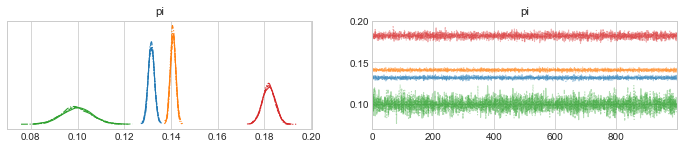

In [13]:
pm.plot_trace(trace)

In [14]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.132,0.001,0.129,0.134,0.0,0.0,6048.0,3097.0,1.0
pi[1],0.141,0.001,0.139,0.143,0.0,0.0,6345.0,2953.0,1.0
pi[2],0.100,0.006,0.088,0.111,0.0,0.0,6820.0,2651.0,1.0
pi[3],0.182,0.003,0.176,0.186,0.0,0.0,6710.0,3140.0,1.0


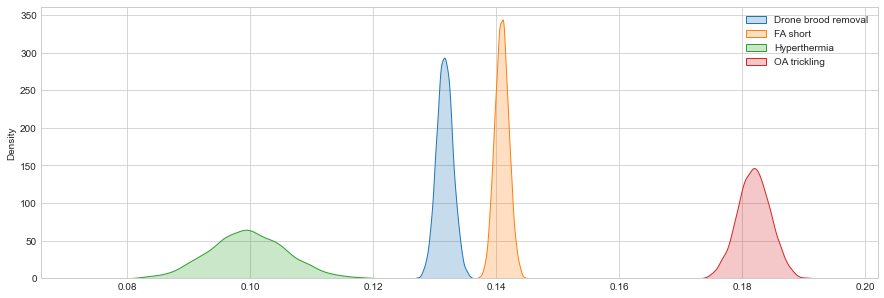

In [15]:
plt.figure(figsize=[15, 5])

for code in code_to_group:
    sns.kdeplot(trace.posterior['pi'][:, :, code].values.flatten(), fill=True, label=code_to_group[code])

plt.legend()

# Export obrazku.
# plt.savefig('out.png', dpi=300)

Stredy posteriornich distribuci odpovidaji jednoduchemu podilu uhynutych vcelstev napric skupinami (spocitano v bunce nize). Narozdil od jednoducheho podilu ale bayesovsky odhad preda i informaci i nejistote odhadu.

In [16]:
df_sum = df.drop(columns=['ID survey', 'Relative loss']).groupby('Group').sum()
df_sum['Lost total'] / df_sum['Wintered']

Group
Drone brood removal    0.131557
FA short               0.140842
Hyperthermia           0.097782
OA trickling           0.181666
dtype: float64

## Alternativni vypocet
Model nize je ekvivalentni s modelem vyse. Jen je pomalejsi a narocnejsi na pamet :) Nema cenu ho pocitat.

In [105]:
df_long = []

for k, row in df.iterrows():
    if k % 1000 == 0:
        print(k)
    
    df_long += [{'Lost': False, 'Group': row['Group']}] * (row['Wintered'] - row['Lost total'])
    df_long += [{'Lost': True, 'Group': row['Group']}] * row['Lost total']

df_long = pd.DataFrame(df_long)
df_long['Group'] = df_long['Group'].astype('category')
df_long['Lost'] = df_long['Lost'].astype('int')
df_long.head()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


,Lost,Group
0,0,OA trickling
1,0,OA trickling
2,0,OA trickling
3,0,OA trickling
4,0,OA trickling


In [99]:
assert len(df_long) == df['Wintered'].sum()

In [107]:
with pm.Model() as model2:
    pi = pm.Beta('pi', 5, 5, shape=df['Group'].unique().size)
    observations = pm.Bernoulli('observations', p=pi[df_long['Group'].cat.codes.values], observed=df_long['Lost'].values)

In [108]:
with model2:
    trace2 = pm.sample()

<ipython-input-108-a5b9f3f3b49f>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace2 = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


/opt/homebrew/Caskroom/miniconda/base/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>]], dtype=object)

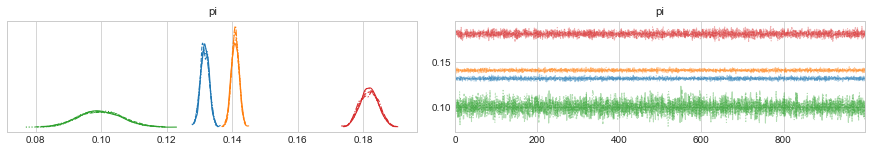

In [112]:
pm.plot_trace(trace2)

In [111]:
pm.summary(trace2)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.132,0.001,0.129,0.134,0.0,0.0,6548.0,3130.0,1.0
pi[1],0.141,0.001,0.139,0.143,0.0,0.0,6435.0,2939.0,1.0
pi[2],0.100,0.006,0.088,0.112,0.0,0.0,6010.0,3075.0,1.0
pi[3],0.182,0.003,0.177,0.187,0.0,0.0,5867.0,2960.0,1.0
